In [1]:
import sys
sys.path.append('../3output_model')
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from generator_class_atmo_3output import DataGenerator_3output_train

2025-03-04 16:55:16.429246: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 16:55:16.436610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-04 16:55:16.444967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-04 16:55:16.447338: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 16:55:16.454162: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Load test data
path_to_df = '../3output_model/pkl_files/test_file.pkl'
df = pd.read_pickle(path_to_df)

# Define generator parameters
n_channels = 3
dimensions = (300, 300)
params = {'batch_size': 32, 'dim': dimensions, 'n_channels': n_channels}

# Create the data generator
generator = DataGenerator_3output_train(df, **params)

In [3]:
path_to_saved_model = "../3output_model/saved_model/3outputs_test/"
layer = tf.keras.layers.TFSMLayer(path_to_saved_model, call_endpoint='serving_default')
input_layer = tf.keras.Input(shape = (300,300, 3)) # e.g. (224, 224, 3)
outputs = layer(input_layer)
model = tf.keras.Model(input_layer, outputs)
model.summary()

I0000 00:00:1741128917.448405  302958 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741128917.468013  302958 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741128917.468114  302958 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741128917.469645  302958 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tfsm_layer (TFSMLayer)          │ [(None, 3), (None, 4), │     4,982,912 │
│                                 │ (None, 2)]             │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,982,912 (19.01 MB)

 Trainable params: 4,978,880 (18.99 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [13]:
# Initialize storage for predictions and true labels
y_true = []
y_pred = []
nu_energy = []
y_pred_prob = []

In [14]:
# Perform batch-wise inference
for i in range(0,200):
    batch_x, batch_y = generator[i]
    preds = model.predict(batch_x)
    #print(batch_y)
    y_true.extend(np.array(batch_y[0]).flatten())  # first label is flavor
    
    if isinstance(preds, dict) and 'output_0' in preds:
        y_pred.extend(np.argmax(preds['output_0'], axis=1)) # Convert softmax to class labels
        y_pred_probs = preds['output_0']  # Store raw probabilities
        y_pred_prob.extend(y_pred_probs)
    else:
        raise ValueError("Model prediction output does not contain 'output_0'")
    
    # Ensure the indexing does not exceed the dataframe size
    start_idx = i * params['batch_size']
    end_idx = min((i + 1) * params['batch_size'], len(df))
    nu_energy.extend(df['NuEnergy'].iloc[start_idx:end_idx].values)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

In [15]:
# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
nu_energy = np.array(nu_energy)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Overall Accuracy: {accuracy:.4f}')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)


Overall Accuracy: 0.7642


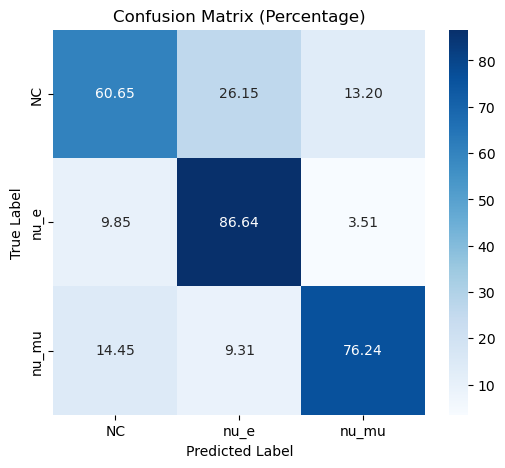

In [16]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix as percentages
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=['NC','nu_e','nu_mu'], yticklabels=['NC','nu_e','nu_mu'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentage)')
plt.show()

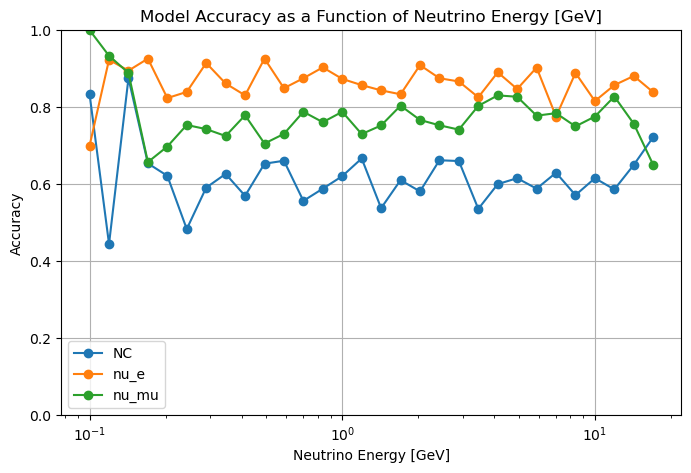

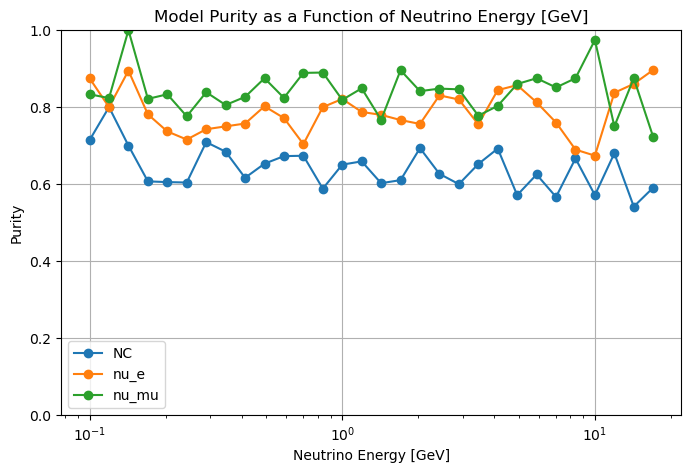

In [17]:
# Calculate accuracy and purity per energy bin
#energy_bins = np.linspace(0, 20, 40)
energy_bins = np.logspace(-1, 2, 40)

energy_accuracy = {0: [], 1: [], 2: []}
energy_purity = {0: [], 1: [], 2: []}

for i in range(len(energy_bins) - 1):
    mask = (nu_energy >= energy_bins[i]) & (nu_energy < energy_bins[i+1])
    if np.sum(mask) > 0:
        for class_label in [0, 1, 2]:
            class_mask = mask & (y_true == class_label)
            if np.sum(class_mask) > 0:
                acc = accuracy_score(y_true[class_mask], y_pred[class_mask])
                energy_accuracy[class_label].append(acc)
            else:
                energy_accuracy[class_label].append(np.nan)
            
            pred_class_mask = mask & (y_pred == class_label)
            if np.sum(pred_class_mask) > 0:
                purity = np.sum(y_true[pred_class_mask] == class_label) / np.sum(pred_class_mask)
                energy_purity[class_label].append(purity)
            else:
                energy_purity[class_label].append(np.nan)
    else:
        for class_label in [0, 1, 2]:
            energy_accuracy[class_label].append(np.nan)
            energy_purity[class_label].append(np.nan)

# Plot accuracy and purity as a function of NuEnergy
#my_labels = ['NC', r"$\nu_e$, 'r$\nu_mu$
             
plt.figure(figsize=(8,5))
for class_label, label_name in zip([0, 1, 2], ['NC', 'nu_e', 'nu_mu']):
    plt.plot(energy_bins[:-1], energy_accuracy[class_label], marker='o', linestyle='-', label=f'{label_name}')
plt.xlabel('Neutrino Energy [GeV]')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.title('Model Accuracy as a Function of Neutrino Energy [GeV]')
plt.legend()
plt.grid()
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(8,5))
for class_label, label_name in zip([0, 1, 2], ['NC', 'nu_e', 'nu_mu']):
    plt.plot(energy_bins[:-1], energy_purity[class_label], marker='o', linestyle='-', label=f'{label_name}')
plt.xlabel('Neutrino Energy [GeV]')
plt.ylabel('Purity')
plt.xscale('log')
plt.title('Model Purity as a Function of Neutrino Energy [GeV]')
plt.legend()
plt.grid()
plt.ylim(0,1)

plt.show()


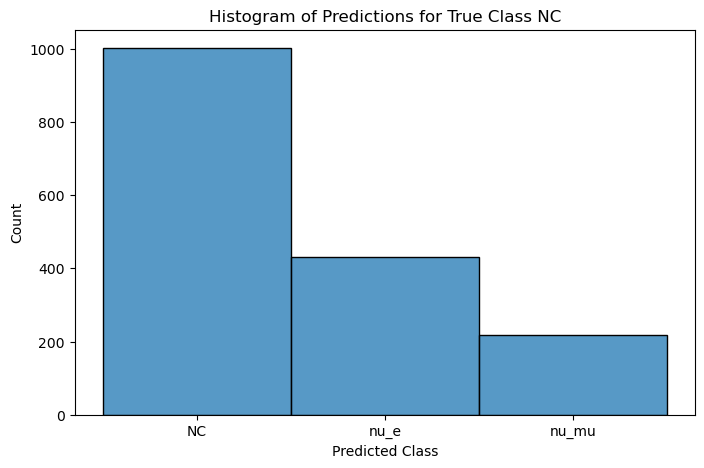

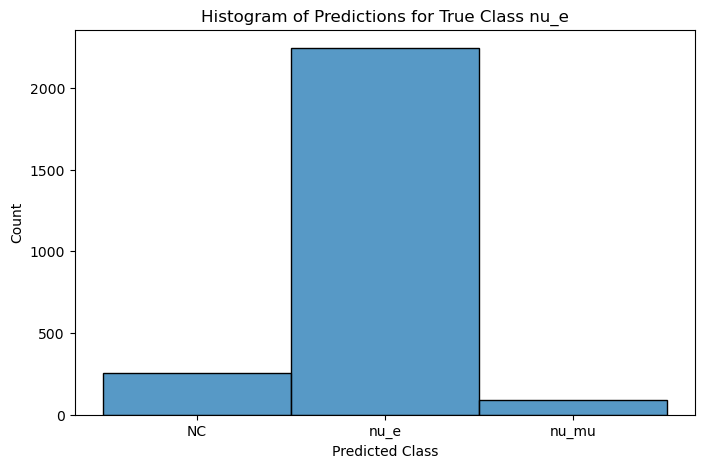

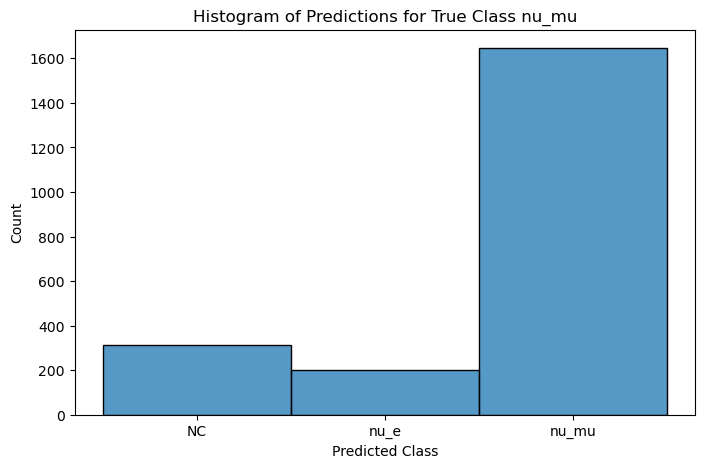

In [18]:
# Plot histograms of y_pred for each class
for class_label, label_name in zip([0, 1, 2], ['NC', 'nu_e', 'nu_mu']):
    plt.figure(figsize=(8,5))
    sns.histplot(y_pred[y_true == class_label], bins=3, discrete=True)
    plt.xlabel('Predicted Class')
    plt.ylabel('Count')
    plt.xticks([0, 1, 2], ['NC', 'nu_e', 'nu_mu'])
    plt.title(f'Histogram of Predictions for True Class {label_name}')
    plt.show()

In [28]:
y_pred_prob[0]

array([0.4511521 , 0.26081148, 0.28803647], dtype=float32)

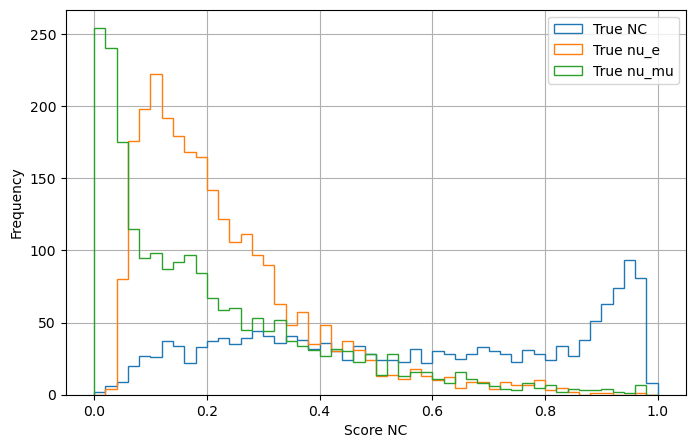

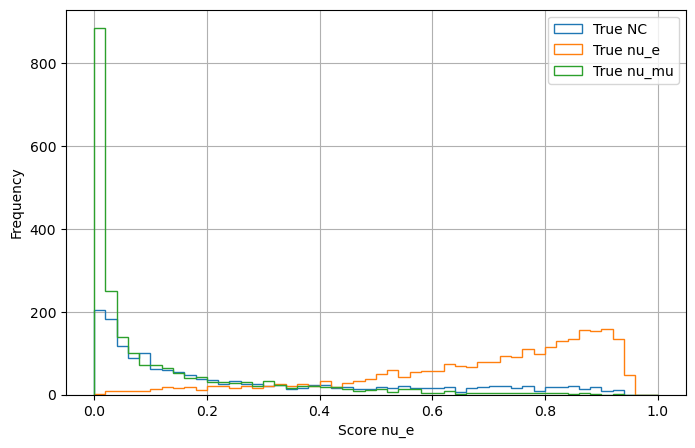

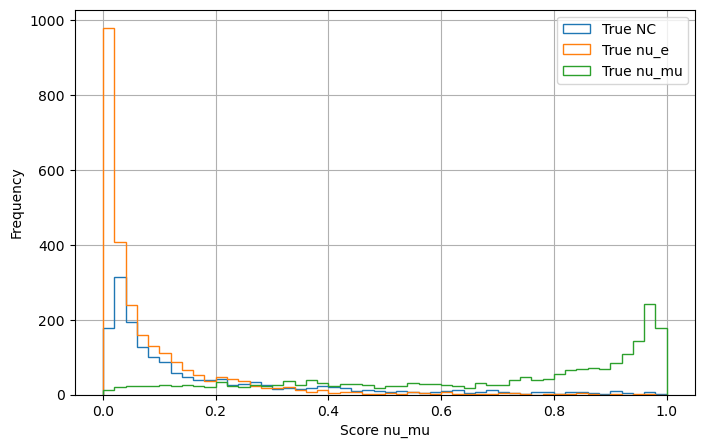

In [41]:
nc_mask = y_true == 0
nue_mask = y_true == 1
numu_mask = y_true == 2
for class_label, label_name in zip([0, 1, 2], ['NC', 'nu_e', 'nu_mu']):
    plt.figure(figsize=(8,5))
    plt.hist(np.array(y_pred_prob)[nc_mask, class_label].flatten(), bins=50, range=(0, 1), alpha=1, label='True NC', histtype='step')
    plt.hist(np.array(y_pred_prob)[nue_mask, class_label].flatten(), bins=50, range=(0, 1), alpha=1, label='True nu_e',  histtype='step')
    plt.hist(np.array(y_pred_prob)[numu_mask, class_label].flatten(), bins=50, range=(0, 1), alpha=1, label='True nu_mu', histtype='step')
    plt.ylabel('Frequency')
    plt.xlabel(f'Score {label_name}')
    plt.legend()
    plt.grid()
    plt.show()

TypeError: list indices must be integers or slices, not tuple